# **Captcha Recognition**

**For Captcha Recognition, OCR (Optical Character Recognition) is used which enables machines to recognize and extract text from images, handwritten documents, or scanned documents and convert it into editable and searchable text. Basically, electronic conversion of the typed, handwritten or printed text images into machine-encoded text. OCR involves complex algorithms that analyze the shapes, patterns, andstrokes within an image to identify characters and words.**

**By: Puyush Gupta**

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras import layers
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
# Path to the data directory
data_dir = Path("/kaggle/input/captcha-recognition/Captcha")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
image_files = os.listdir(data_dir)
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)            # set of all unique characters 
characters = sorted(list(characters))

print("Total images found: ", len(images))
print("Total labels found: ", len(labels))
print("Total number of unique characters: ", len(characters))
print("\n\nCharacter Vocabulary:\n", characters)

Total images found:  113062
Total labels found:  113062
Total number of unique characters:  60


Character Vocabulary:
 ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


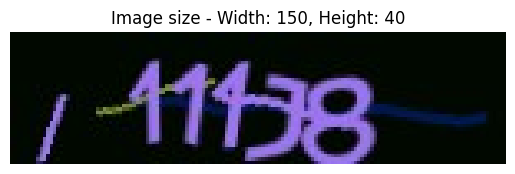

In [5]:
# Inspecting an image from the dataset
image_path = images[0]
image = Image.open(image_path)

# Get the size of the image
img_width, img_height = image.size

# Display the image
plt.imshow(image)
plt.title(f"Image size - Width: {img_width}, Height: {img_height}")
plt.axis('off')
plt.show()

In [5]:
# Process only the first 10 images to check dimension of images
for i, file_name in enumerate(image_files[:10]):
    file_path = os.path.join(data_dir, file_name)
    # Check if the file is an image file (you can extend this check for specific extensions)
    if file_name.endswith('.jpg') or file_name.endswith('.png') or file_name.endswith('.jpeg'):
        try:
            # Open the image file
            img = Image.open(file_path)
            # Get image dimensions (width x height)
            width, height = img.size
            print(f"Dimensions of {file_name}: {width} x {height}")
            
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            

# Checking if all images in the dataset have the same dimensions
count1 = 0
for image_path in tqdm(images):
    # Open the image using PIL
    temp_image = Image.open(image_path)
    
    # Get the size of the image
    temp_width, temp_height = temp_image.size
    
    if (temp_width != img_width) or (temp_height != img_height):
        count1 += 1
        
print(f"Number of images whose size is not {img_width} X {img_height}: {count1}")    

Dimensions of iBLx2.jpg: 150 x 40
Dimensions of KyOyd.jpg: 150 x 40
Dimensions of pz4L2.jpg: 150 x 40
Dimensions of ZzpSw.jpg: 150 x 40
Dimensions of 9KrP5.jpg: 150 x 40
Dimensions of NqsnV.jpg: 150 x 40
Dimensions of 3XDYA.jpg: 150 x 40
Dimensions of 8cG1Z.jpg: 150 x 40
Dimensions of 4k21z.jpg: 150 x 40
Dimensions of 3MYNZ.jpg: 150 x 40


100%|██████████| 113062/113062 [16:02<00:00, 117.44it/s]

Number of images whose size is not 150 X 40: 0


In [6]:
# Maximum length of any captcha in the dataset
max_len = max([len(label) for label in labels])
print("Max Length of labels: ", max_len)

# Checking if all images in the dataset have the same label length
for label in tqdm(labels):
    count2 = 0
    if len(label) != max_len:
        count2 += 1
        
print(f"Number of images whose label size is not {max_len}: {count2}")

Max Length of labels:  5


100%|██████████| 113062/113062 [00:00<00:00, 1162622.80it/s]

Number of images whose label size is not 5: 0


In [7]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Factor by which the image is going to be downsampled by the convolutional blocks. 
downsample_factor = 8
batch_size = 32
padding_token = 99
image_width = 128
image_height = 32

# **Data Preparation and Preprocessing**

In [8]:
def split_data(images, labels, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    
    train_samples = int(size * train_size)
    val_samples = int(size * val_size)

    train_indices = indices[:train_samples]
    val_indices = indices[train_samples:train_samples + val_samples]
    test_indices = indices[train_samples + val_samples:]

    X_train, y_train = images[train_indices], labels[train_indices]
    X_val, y_val = images[val_indices], labels[val_indices]
    X_test, y_test = images[test_indices], labels[test_indices]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(np.array(images), np.array(labels))

In [9]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  # Resizing images without distortion
  # Aspect ratio is preserved.
  # Content of the images is not affected.
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check tha amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
  )
  # Transpose the image because we want the time dimension to correspond to the width of the image.
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image

In [10]:
def encode_single_sample(img_path, label, img_size=(image_width, image_height)):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Resize to the desired size
    img = distortion_free_resize(img, img_size)
    # 4. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)/255.0
    # 5. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 6. Get length of label
    length = tf.shape(label)[0]
    # 7. Find padding size
    pad_amount = max_len - length
    
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    # Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [11]:
# Create TensorFlow datasets for train, validation, and test
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Print dataset sizes
print(f"Number of batches in train dataset: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Number of batches in  validation dataset: {tf.data.experimental.cardinality(validation_dataset).numpy()}")
print(f"Number of batches in  test dataset: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Number of batches in train dataset: 2827
Number of batches in  validation dataset: 354
Number of batches in  test dataset: 354


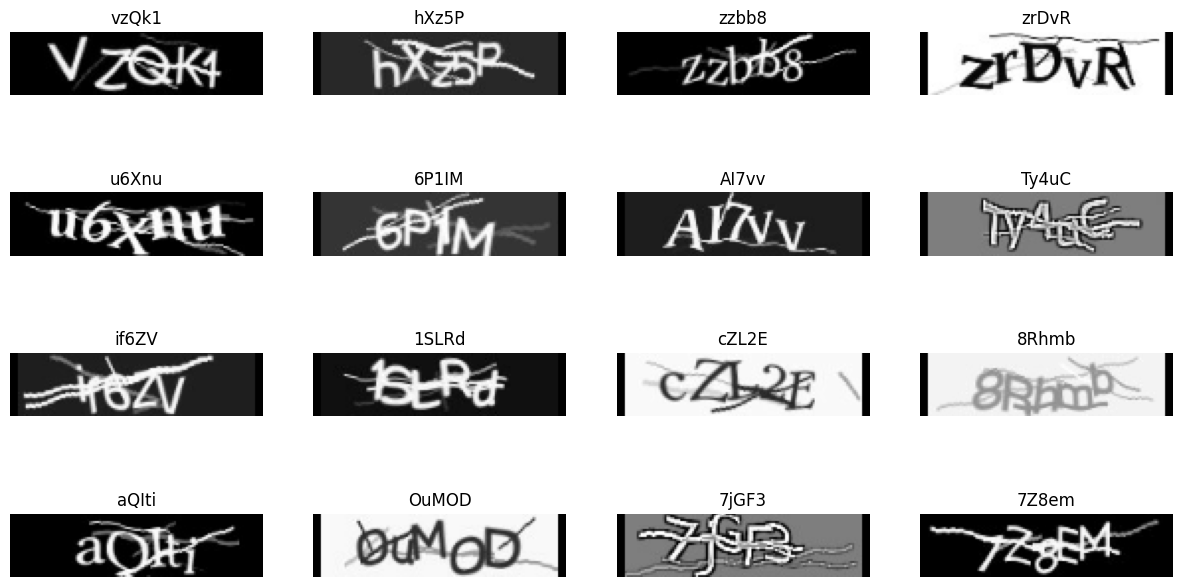

In [12]:
for data in train_dataset.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16): 
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()

# **Model Architecture, Training, and Loss Calculation**

In [13]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [14]:
# Checking the shape of images and labels in each batch

for batch in train_dataset:
    images = batch["image"]
    labels = batch["label"]
    print("Image Batch Shape: ", images.shape)
    print("Labels Batch Shape: ", labels.shape)
    break

Image Batch Shape:  (32, 128, 32, 1)
Labels Batch Shape:  (32, 5)


In [15]:
def residual_block(X,filters):
    # Retrieve Filters
    F1, F2 = filters
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = layers.Conv2D(filters = F1, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(alpha=0.1)(X)

    # Second component of main path 
    X = layers.Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = layers.BatchNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = layers.Add()([X, X_shortcut])
    X = layers.LeakyReLU(alpha=0.1)(X)
    return X

In [16]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(image_width, image_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    # First conv block
    x = layers.Conv2D(32,(3, 3),kernel_initializer="he_normal",padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Add a residual block
    x = residual_block(x, [64, 32]) 
    x = layers.MaxPooling2D((2, 2))(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),kernel_initializer="he_normal",padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Add a residual block
    x = residual_block(x, [128, 64]) 
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Third conv block
    x = layers.Conv2D(128,(3, 3),kernel_initializer="he_normal",padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Add a residual block
    x = residual_block(x, [256, 128]) 
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    
    # Downsampling reduces spatial dimensions, potentially losing fine-grained details. 
    # If you downsample too aggressively, important information might be discarded, making it harder for the model to learn intricate patterns in the data.
    # Smaller feature maps mean fewer parameters and computations, reducing the computational load.
    # Downsampling can act as a form of regularization by preventing the model from fitting too closely to the training data. 
    
    # Three max pool layers have been used with pool size and strides 2. Hence, downsampled feature maps are 8x smaller
    # The number of filters in the last layer is 128. Reshape accordingly before passing the output to the RNN part of the model
    new_shape = ((image_width // downsample_factor), (image_height // downsample_factor) * 128)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2, kernel_initializer="he_normal"))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, kernel_initializer="he_normal"))(x)

    # Output layer
    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model")
    opt = keras.optimizers.Adam(learning_rate=0.001)

    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 128, 32, 32)          128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 32, 32)          0         ['batch_normalization[

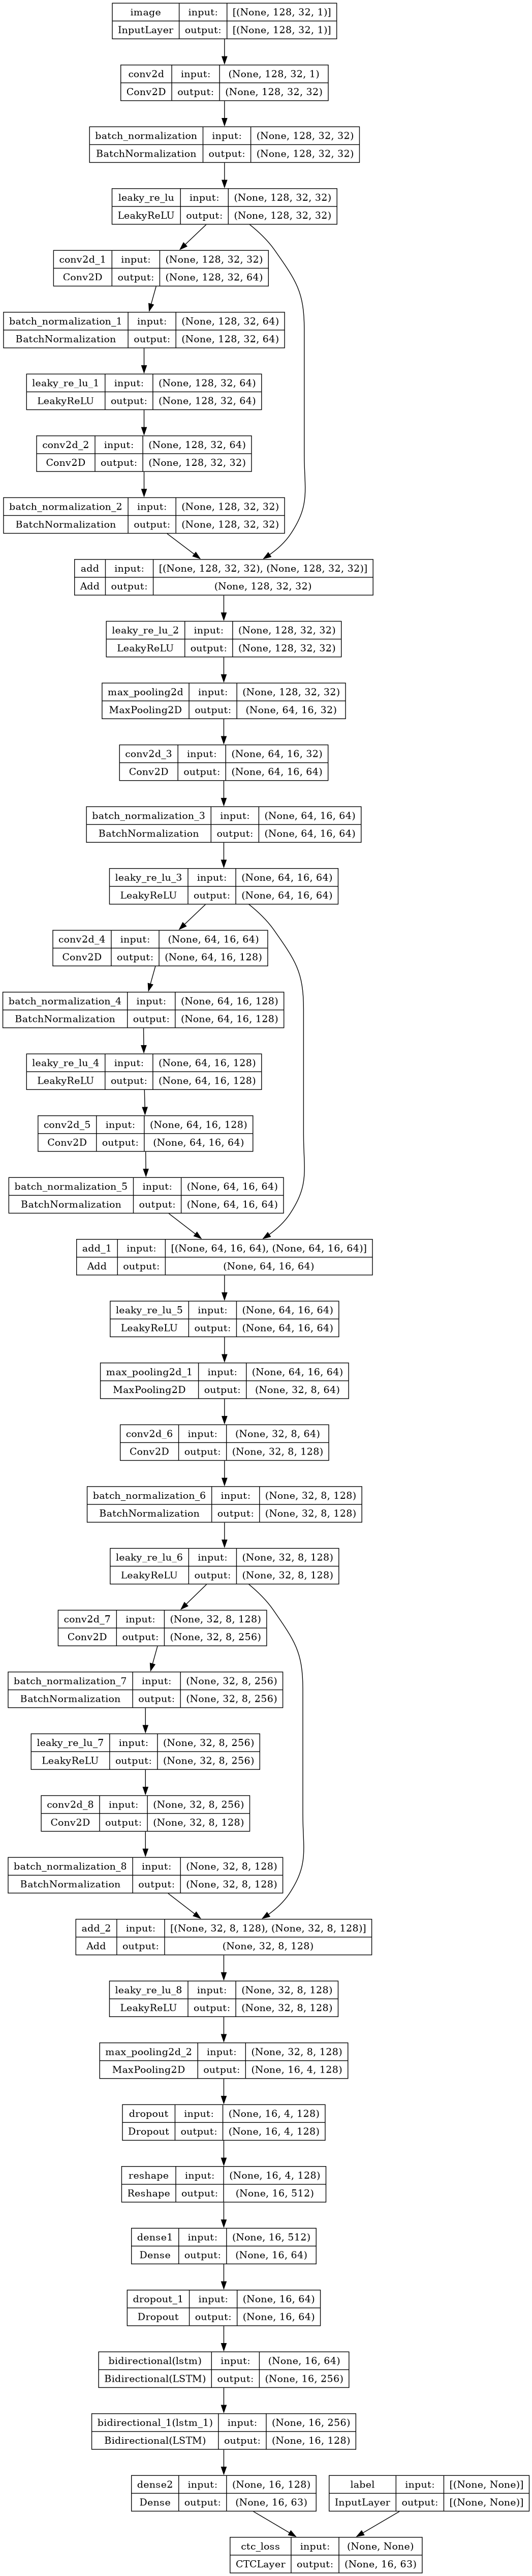

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=100)

In [18]:
# Edit Distance is the most widely used metric for evaluating OCR models. We will use it as a callback to monitor ‘our model.

validation_images = []
validation_labels = []

for batch in validation_dataset:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])
    
# Now we create a callback to monitor the edit distance
def calculate_edit_distance(labels, predictions):
    
  # Get a single batch and convert its labels to sparse tensors.
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(
    predictions, input_length=input_len, greedy=True
  )[0][0][:, :max_len]
  sparse_predictions = tf.cast(
    tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
  )

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model
  def on_epoch_end(self, epoch, logs = None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
    print(f"Mean edit distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")

In [19]:
epochs = 30

prediction_model = tf.keras.models.Model(
   model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

# callback for edit distance 
edit_distance_callback = EditDistanceCallback(prediction_model)

# Add early stopping
early_stopping_patience = 5  
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Add ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1, mode="min", min_lr=5e-7,
)

# Train the model with callbacks.
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[edit_distance_callback, early_stopping, reduce_lr]
)

Epoch 1/30


2024-02-09 09:58:08.108602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inocr_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707472692.205689      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 2s 2s/step
Mean edit distance for each 1:  4.5506
2827/2827 [==============================] - 211s 69ms/step - loss: 20.2796 - val_loss: 16.2965 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - 0s 22ms/step
Mean edit distance for each 2:  2.4022
2827/2827 [==============================] - 154s 55ms/step - loss: 11.7320 - val_loss: 7.0312 - lr: 0.0010
Epoch 3/30
1/1 [==============================] - 0s 23ms/step
Mean edit distance for each 3:  1.1655
2827/2827 [==============================] - 153s 54ms/step - loss: 5.9441 - val_loss: 3.5043 - lr: 0.0010
Epoch 4/30
1/1 [==============================] - 0s 22ms/step
Mean edit distance for each 4:  0.7737
2827/2827 [==============================] - 154s 54ms/step - loss: 3.6894 - val_loss: 2.4993 - lr: 0.0010
Epoch 5/30
1/1 [==============================] - 0s 23ms/step
Mean edit distance for each 5:  0.6275
2827/2827 [==============================] - 153s 54ms/step - loss: 2.80

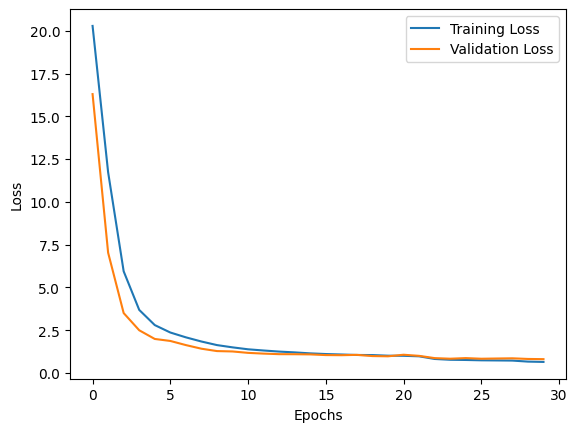

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Saving Model and it's Weights**

In [21]:
model.save_weights('/kaggle/working/ocr_model_weights.h5')
prediction_model.save_weights('/kaggle/working/ocr_model_pred_weights.h5')

# Below is working saved models
model.save("/kaggle/working/ocr_model.keras")
prediction_model.save("/kaggle/working/ocr_model_pred.keras")

# **Let's calculate Accuracy**

In [22]:
max_len = 5
characters =  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)
image_width = 128
image_height = 32

In [23]:
y_test = []

for batch in test_dataset:
    # Assuming the key for labels is 'label'
    labels_batch = batch["label"]  
    for label in labels_batch:
        # Convert label integers back to characters using the num_to_char mapping
        label_chars = num_to_char(label)
        # Combine characters into a single string (if necessary)
        label_str = tf.strings.reduce_join(label_chars, axis=-1).numpy().decode("utf-8")
        y_test.append(label_str)

# Now test_labels contains the labels extracted from the test dataset
len(y_test)

11307

# **Model Predictions on Test Images**

In [24]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text

In [25]:
# Initialize an empty list to store predictions
y_pred = []

for batch in test_dataset:
    batch_images = batch["image"]
    # Predict on the batch of images
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    y_pred.extend(pred_texts)

# Convert the list of predictions to a NumPy array
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 452ms/step


In [26]:
from sklearn.metrics import accuracy_score

# For classification tasks (if y_pred contains predicted labels):
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.75%


(32, 128, 32, 1)
1/1 [==============================] - 1s 1s/step


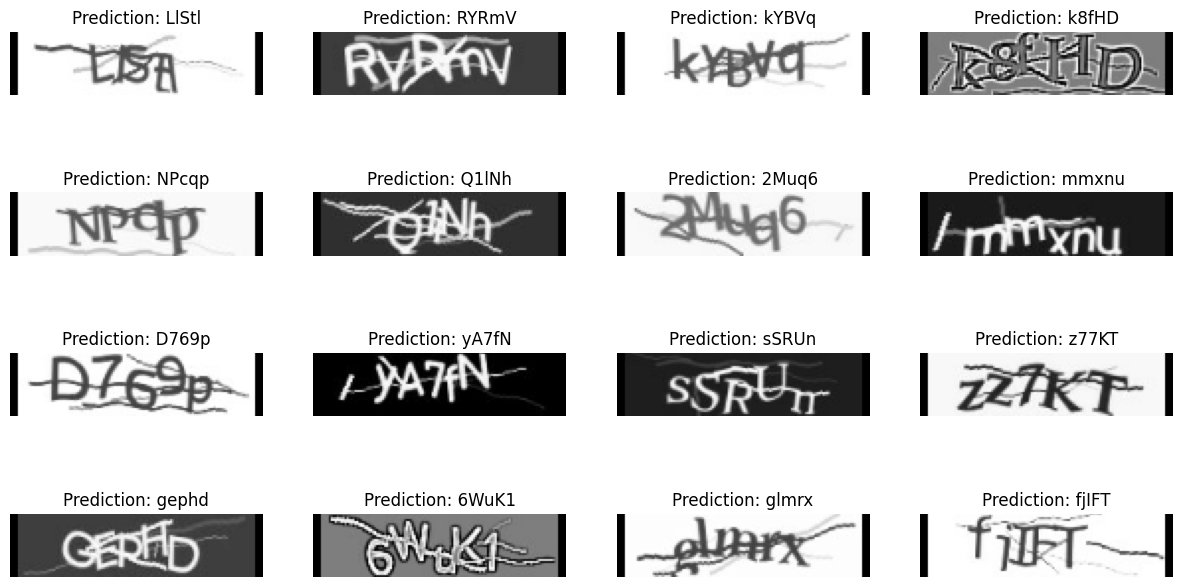

In [27]:
# Load the saved model
loaded_model = keras.models.load_model("/kaggle/working/ocr_model_pred.keras", custom_objects={"CTCLayer": CTCLayer})
loaded_model.load_weights("/kaggle/working/ocr_model_pred_weights.h5")

for batch in test_dataset.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = loaded_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

# **Thank You!**